In [ ]:
!nvidia-smi

Wed Jul 30 15:33:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.5/112.6 GB disk)


In [ ]:
# pretrained weights detection with uniform image
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/test.jpg' save=True

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/test.jpg: 384x640 3 persons, 18 cars, 42.9ms
Speed: 10.2ms preprocess, 42.9ms inference, 306.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


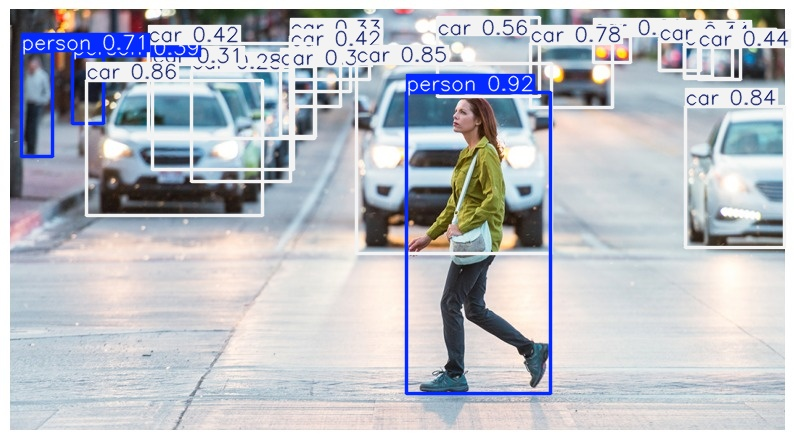

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/predict/test.jpg', width=600)

## Fine-tune YOLO11 on custom dataset

In [ ]:
!pip install roboflow

!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow
rf = Roboflow(api_key="PREtYuS13VXPKlpKYGKD")
project = rf.workspace("capstone-cra8x").project("citypersons-woqjq-ike0o-dtqfy")
version = project.version(1)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Citypersons-1 in yolov11:: 100%|██████████| 6962/6962 [00:02<00:00, 3077.13it/s]


## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 61.4MB/s]
New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Citypersons-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, clas

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1753889938.3d8fcc325825.2017.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


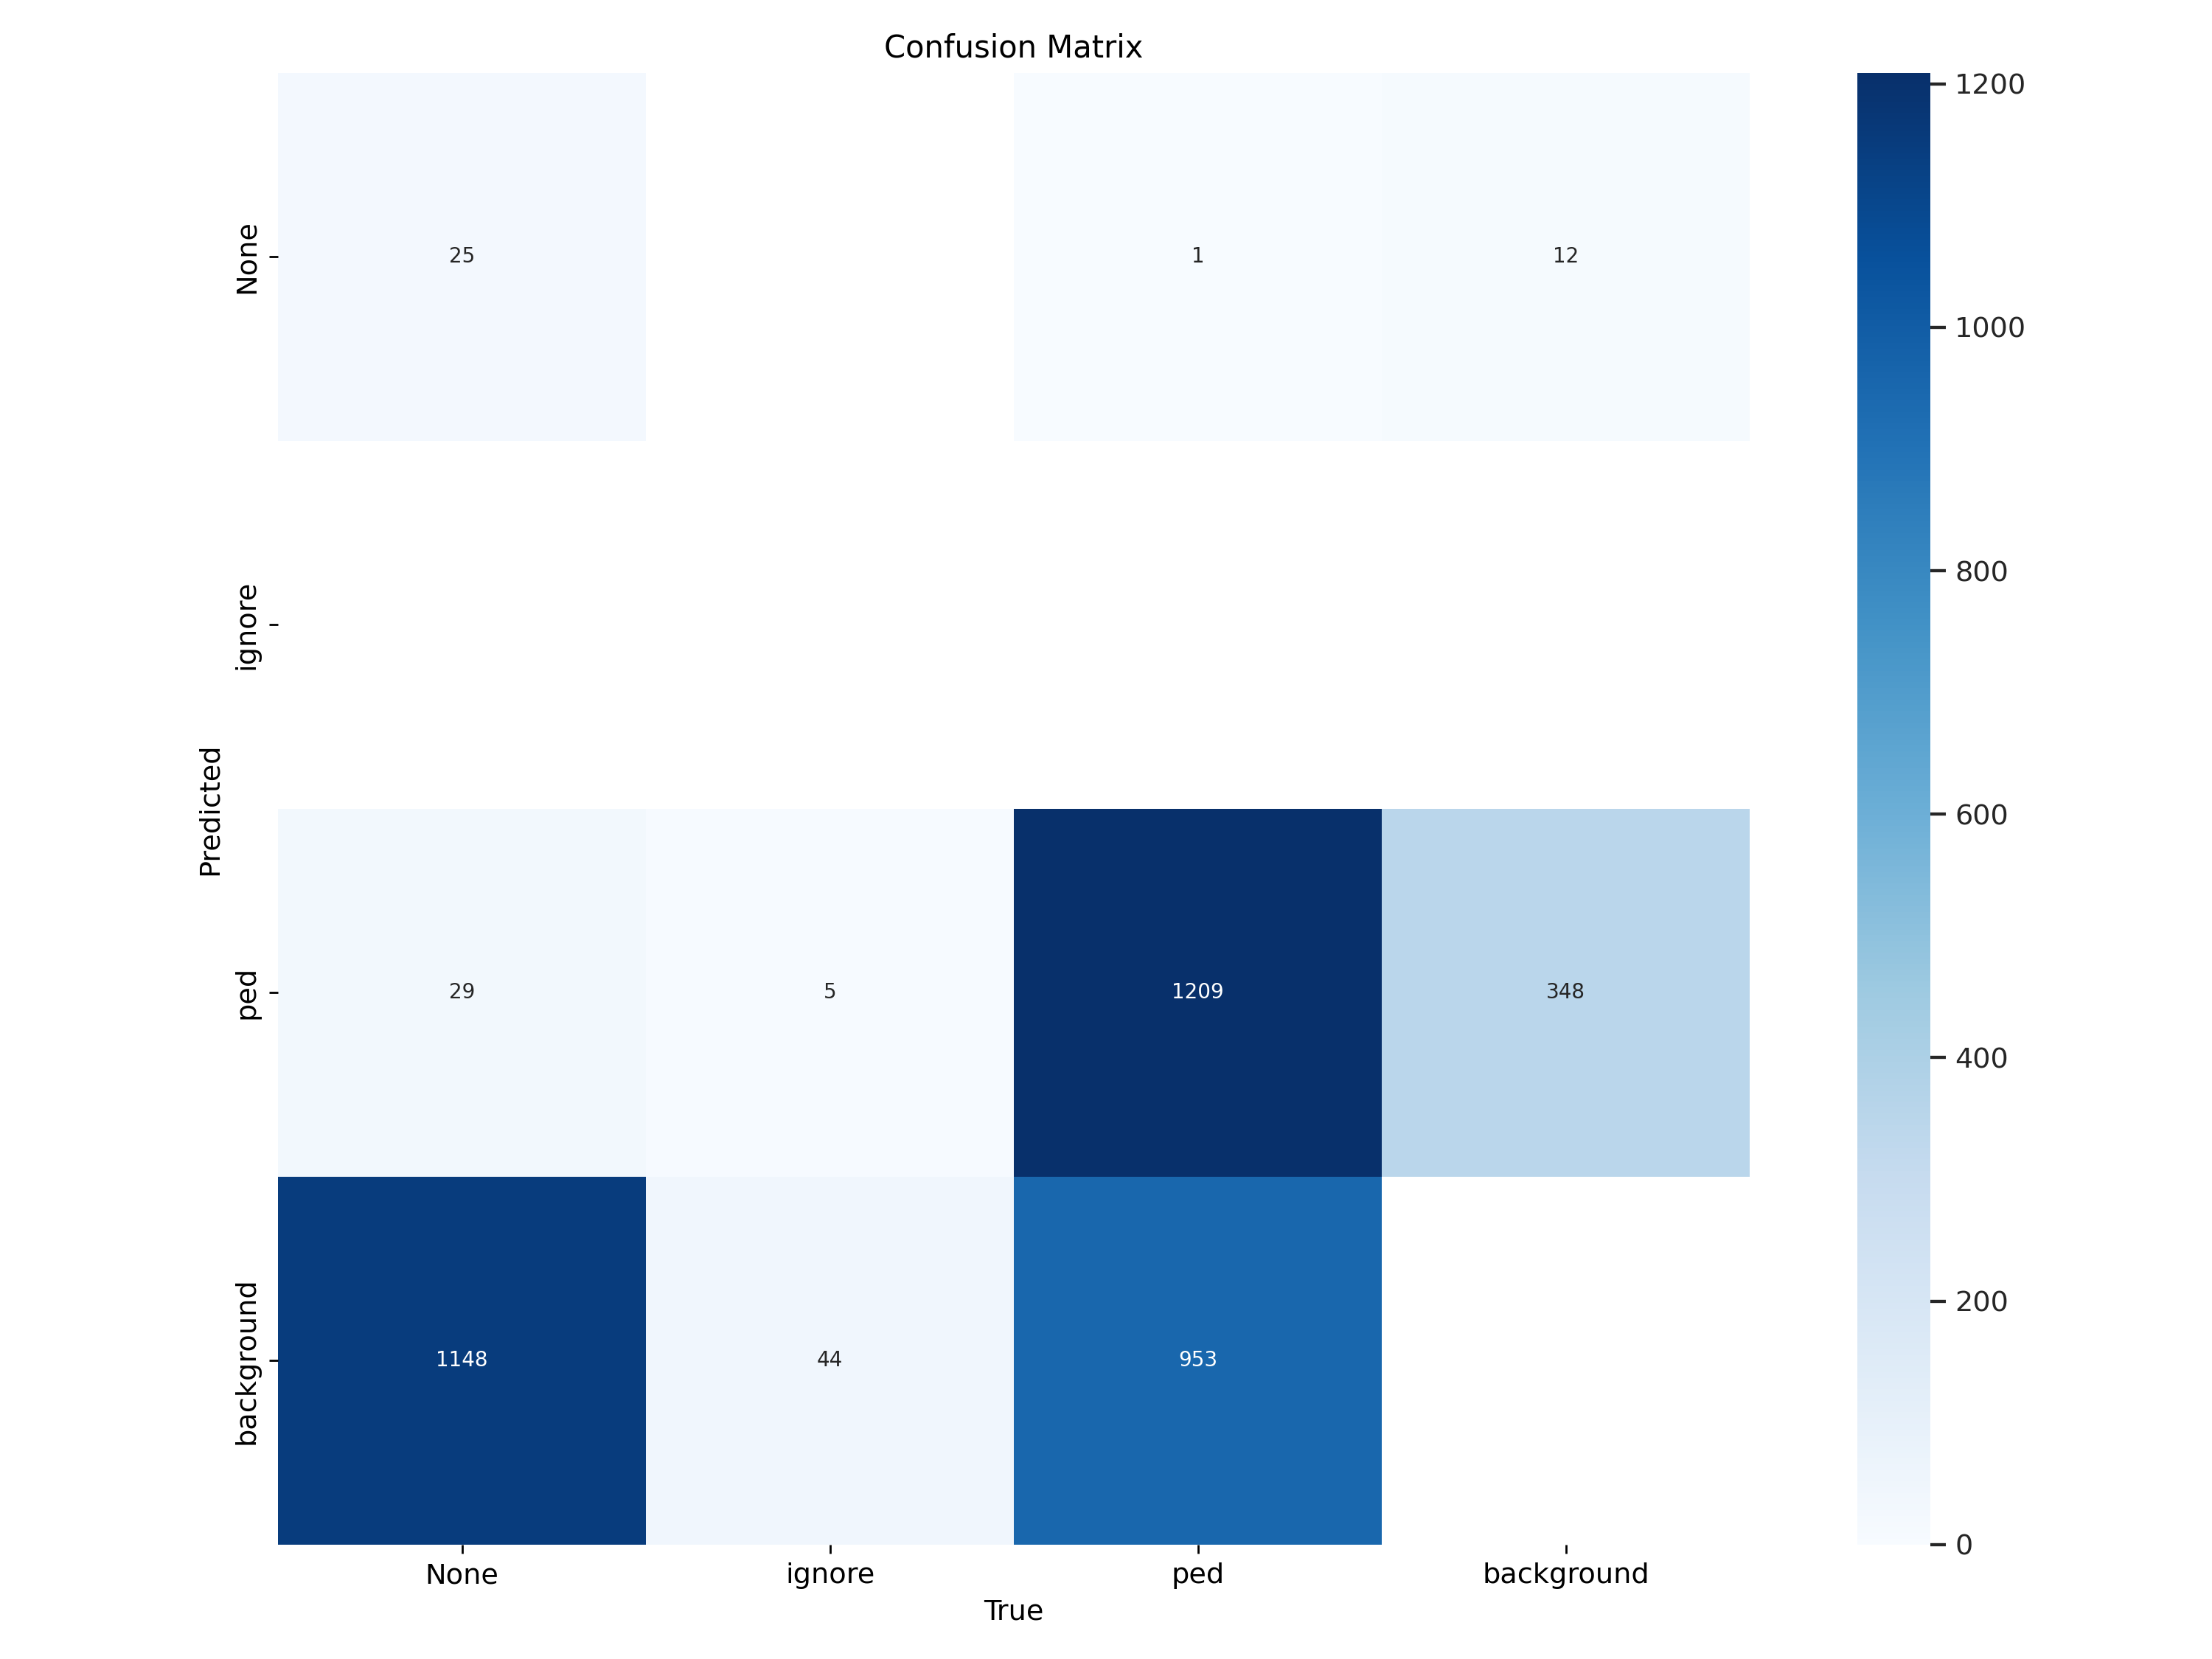

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

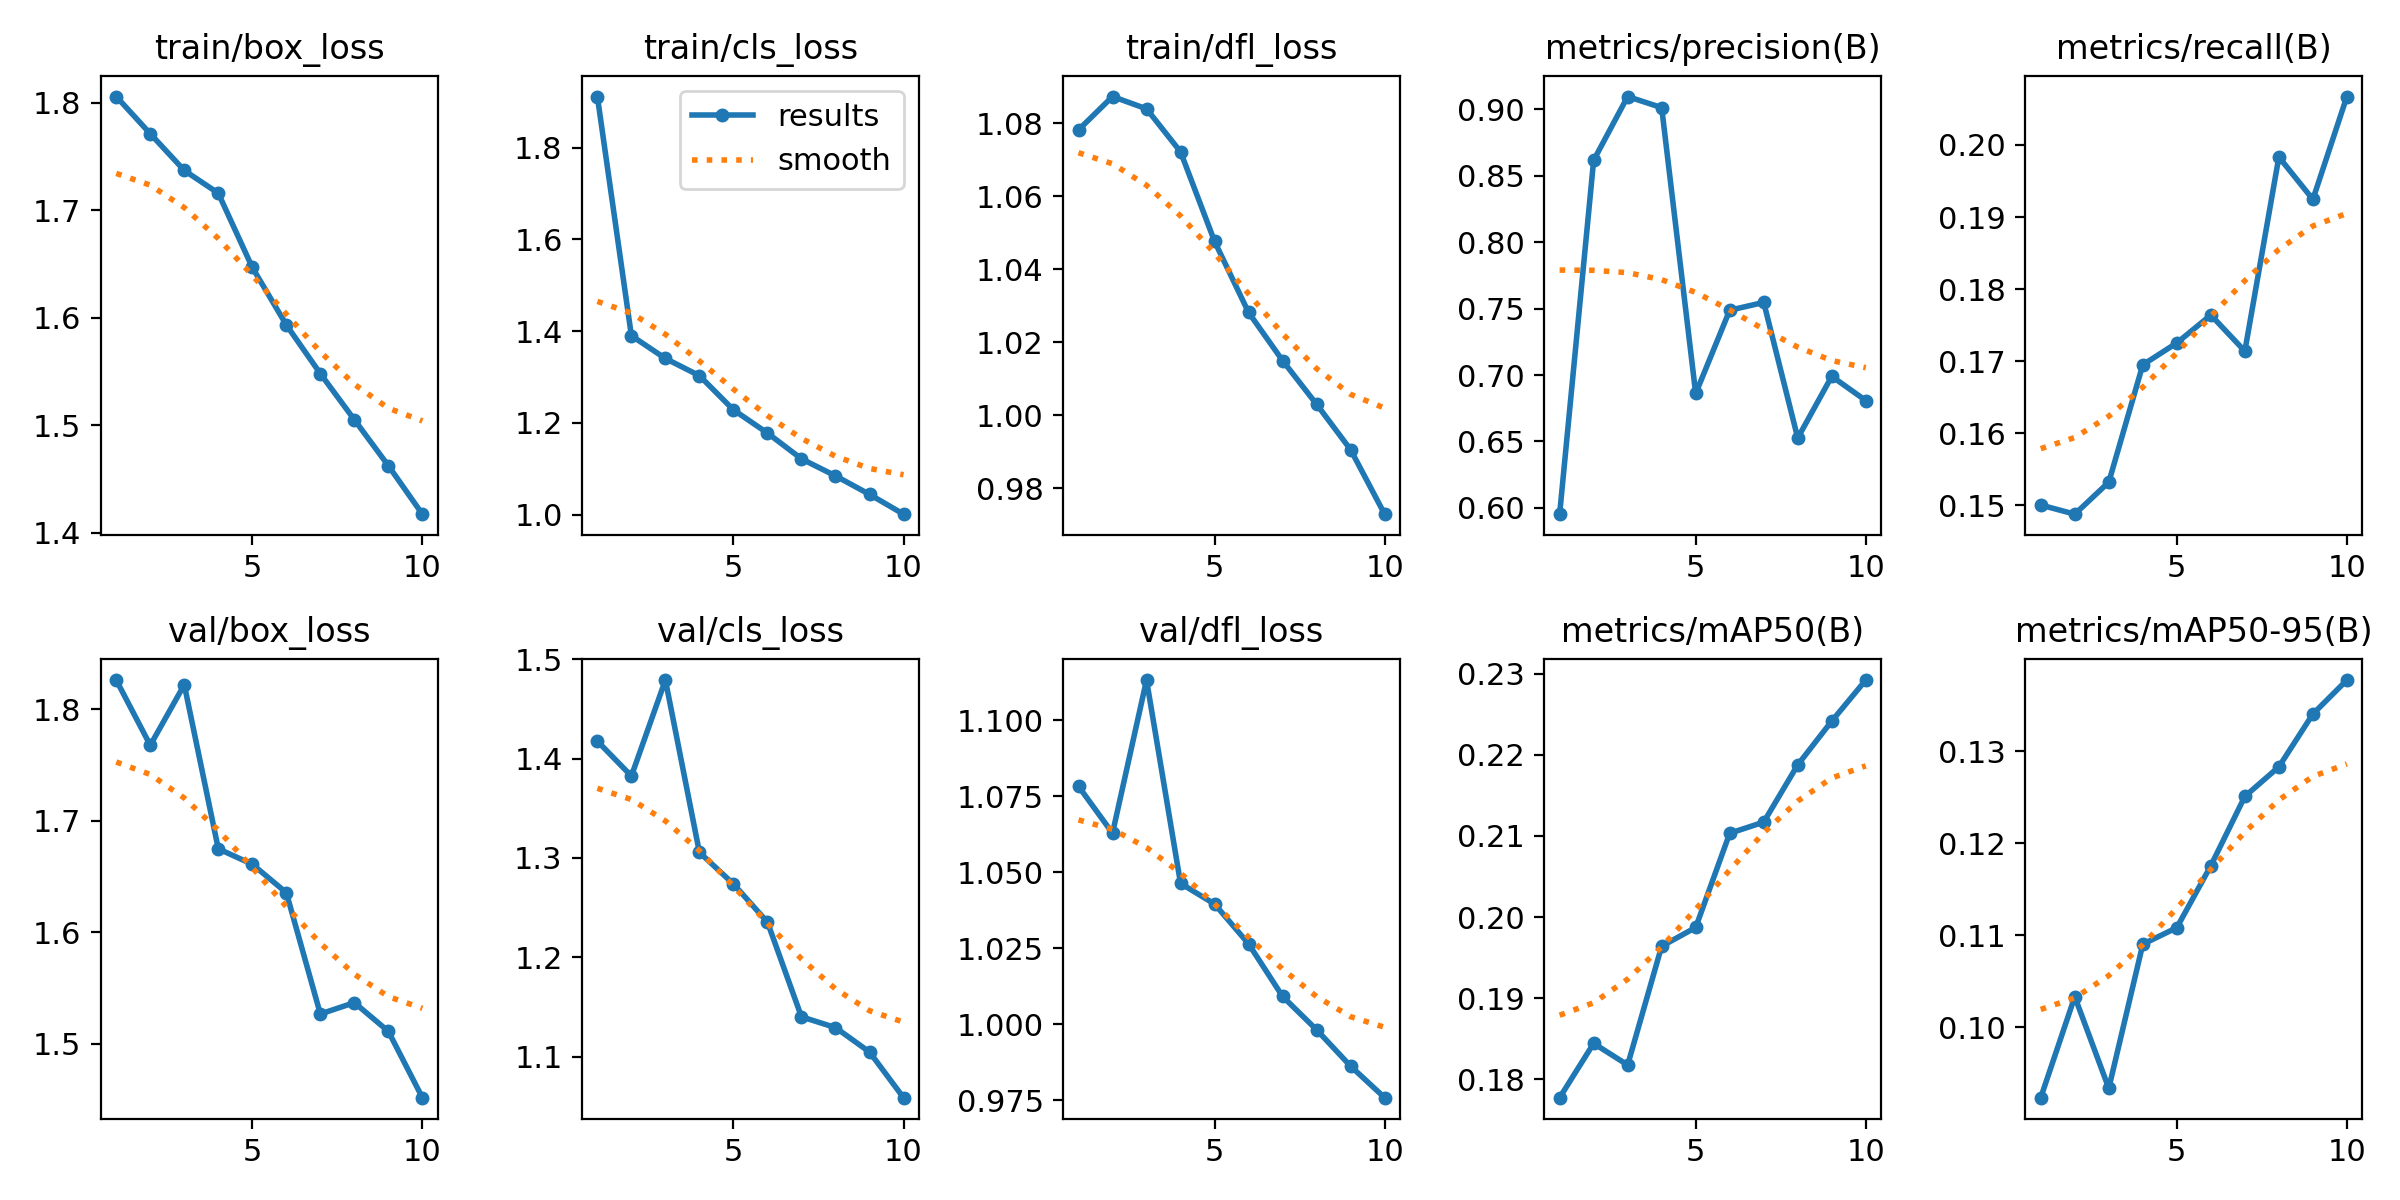

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

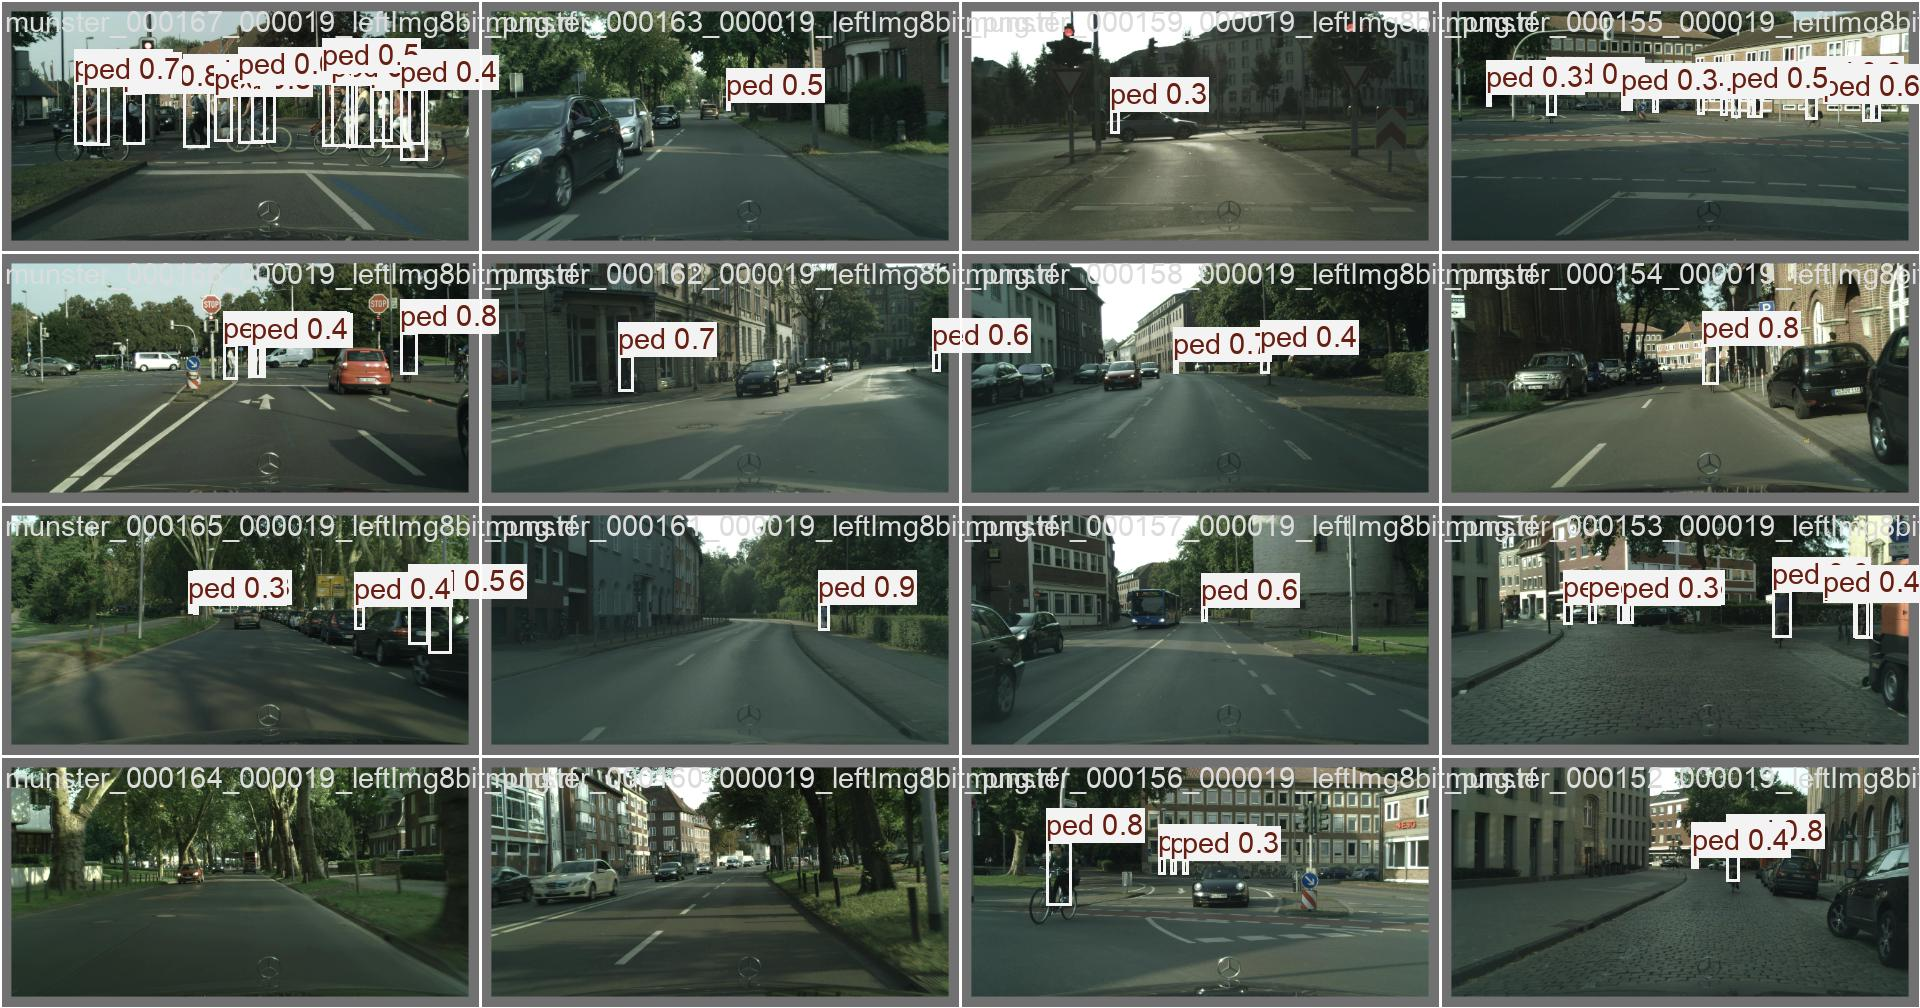

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Citypersons-1/valid/labels.cache... 342 images, 13 backgrounds, 0 corrupt: 100% 342/342 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 22/22 [00:05<00:00,  4.19it/s]
                   all        342       3414      0.671      0.209      0.229      0.138
                  None        281       1202      0.365     0.0258     0.0402     0.0129
                ignore         42         49          1          0    0.00448    0.00216
                   ped        289       2163       0.65      0.601      0.643      0.399
Speed: 0.5ms preprocess, 5.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/341 /content/datasets/Citypersons-1/test/images/aachen_000002_000019_leftImg8bit_png.rf.fb4b114d0b573cf6bb0a85130fb6a52c.jpg: 320x640 4 peds, 45.5ms
image 2/341 /content/datasets/Citypersons-1/test/images/aachen_000003_000019_leftImg8bit_png.rf.b7e8f36ea4590701f8e2c62981c36bd3.jpg: 320x640 (no detections), 10.4ms
image 3/341 /content/datasets/Citypersons-1/test/images/aachen_000004_000019_leftImg8bit_png.rf.c3e2a738d43c36b73f96cad7f7d8ed7d.jpg: 320x640 7 peds, 10.3ms
image 4/341 /content/datasets/Citypersons-1/test/images/aachen_000008_000019_leftImg8bit_png.rf.7ac575b86dd24472f21da0cd1aa2c39c.jpg: 320x640 6 peds, 10.3ms
image 5/341 /content/datasets/Citypersons-1/test/images/aachen_000009_000019_leftImg8bit_png.rf.87da82fe21899a43dfa1710097f55e55.jpg: 320x640 1 None, 6 peds, 10.3ms
image 6/341 /content/datasets/C

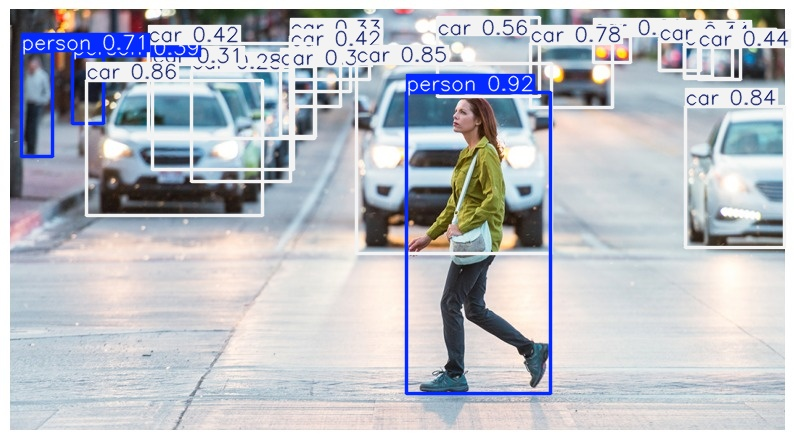

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")